In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

In [335]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [336]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [345]:
all_train_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,7): #1,2,3,5,6,  7,8,  9, 10
    all_train_data_list.append([i, 11, '1L', 'NA'])
    all_train_data_list.append([i, 12, '1L', 'NA'])
    all_train_data_list.append([i, 13, '1L', 'NA'])
    all_train_data_list.append([i, 14, '1L', 'NA'])
    all_train_data_list.append([i, 15, '1L', 'NA'])
    all_train_data_list.append([i, 11, '2R', 'NA'])
    all_train_data_list.append([i, 12, '2R', 'NA'])
    all_train_data_list.append([i, 13, '2R', 'NA'])
    all_train_data_list.append([i, 14, '2R', 'NA'])
    all_train_data_list.append([i, 15, '2R', 'NA'])    
    
print(all_train_data_list)

[[1, 11, '1L', 'NA'], [1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 15, '1L', 'NA'], [1, 11, '2R', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [1, 15, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 15, '1L', 'NA'], [2, 11, '2R', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [2, 15, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 15, '1L', 'NA'], [3, 11, '2R', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [3, 15, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 15, '1L', 'NA'], [4, 11, '2R', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [4, 15, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 15, '1L', 'NA'], [5, 11, '2R', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R'

In [346]:
step_train_data_list = []
step_valid_data_list = []
for i in range(11, 16):
    step_train_data_list_part = [j for j in all_train_data_list if j[1]!=i]
    step_valid_data_list_part = [j for j in all_train_data_list if j[1]==i]
    print(len(step_train_data_list_part))
    print(step_train_data_list_part)
    print('-----')
    print(len(step_valid_data_list_part))
    print(step_valid_data_list_part)
    print('=====')
    step_train_data_list.append(step_train_data_list_part)
    step_valid_data_list.append(step_valid_data_list_part)
    
    

48
[[1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 15, '1L', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [1, 15, '2R', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 15, '1L', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [2, 15, '2R', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 15, '1L', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [3, 15, '2R', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 15, '1L', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [4, 15, '2R', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 15, '1L', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R', 'NA'], [5, 14, '2R', 'NA'], [5, 15, '2R', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 15, '1L', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R', 'NA'], [6, 15, '

In [419]:
batch_size = 256
train_x_list, train_y_list = [], []
print(batch_size)

for step_train_data in step_train_data_list:
    data_x, data_y = [], []
    
    for i in step_train_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        for dx in data_x_segement:
            data_x.extend(dx)
        for dy in data_y_segement:
            data_y.extend(dy)
    
    print(len(data_x))
#     print(len(data_y))
    
    order = list(range(0,len(data_x),1))
    random.shuffle(order)

    train_x = [data_x[i] for i in order]
#     train_x.extend([i for i in train_x[:batch_size]])
#     train_x.extend([train_x[i] for i in range(0, batch_size)])
    train_y = [data_y[i] for i in order]
#     train_y.extend([i for i in train_y[:batch_size]])
#     train_y.extend([train_y[i] for i in range(0, batch_size)])

    print(len(train_x))
    
    train_x_list.append(train_x)
    train_y_list.append(train_y)

256
95497
95497
99274
99274
94683
94683
90343
90343
92943
92943


In [420]:
valid_x_list, valid_y_list = [], []

for step_valid_data in step_valid_data_list:
    valid_x, valid_y=[], []
    for i in step_valid_data:
        data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
        valid_x.extend(data_x_segement)
        valid_y.extend(data_y_segement)
    
    print(len(valid_x))
#     print(len(valid_y))
    
    valid_x_list.append(valid_x)
    valid_y_list.append(valid_y)

56
51
60
56
56


In [421]:
step_test_list = []
for i in range(1,7):
#     step_test_list.append([i, 11, '1L', 'NA'])
#     step_test_list.append([i, 12, '1L', 'NA'])
#     step_test_list.append([i, 13, '1L', 'NA'])
#     step_test_list.append([i, 14, '1L', 'NA'])
    step_test_list.append([i, 15, '1L', 'NA'])
#     step_test_list.append([i, 11, '2R', 'NA'])
#     step_test_list.append([i, 12, '2R', 'NA'])
#     step_test_list.append([i, 13, '2R', 'NA'])
#     step_test_list.append([i, 14, '2R', 'NA'])
    step_test_list.append([i, 15, '2R', 'NA'])    
        
print(step_test_list)

[[1, 15, '1L', 'NA'], [1, 15, '2R', 'NA'], [2, 15, '1L', 'NA'], [2, 15, '2R', 'NA'], [3, 15, '1L', 'NA'], [3, 15, '2R', 'NA'], [4, 15, '1L', 'NA'], [4, 15, '2R', 'NA'], [5, 15, '1L', 'NA'], [5, 15, '2R', 'NA'], [6, 15, '1L', 'NA'], [6, 15, '2R', 'NA']]


In [422]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

56
56
[50, 86, 745, 45, 50, 86, 745, 45, 83, 1057, 77, 28, 83, 1057, 77, 28, 1105, 240, 1105, 240, 168, 1044, 57, 991, 92, 807, 74, 727, 168, 1044, 57, 991, 92, 807, 74, 727, 20, 309, 597, 107, 363, 251, 1069, 20, 309, 597, 107, 363, 251, 1069, 574, 1111, 744, 574, 1111, 744]


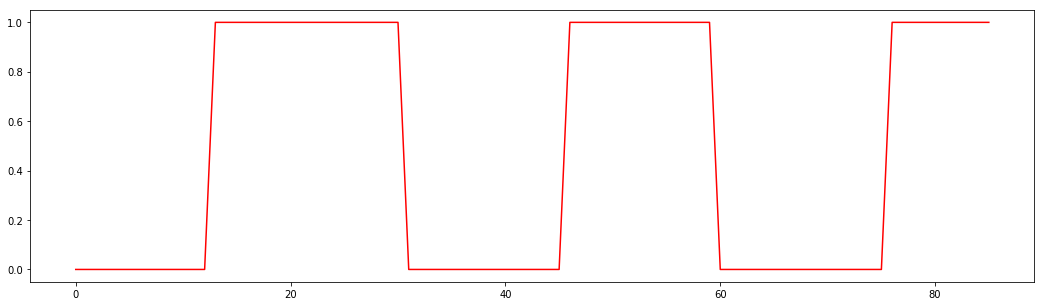

In [423]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [424]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
#     cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.03).minimize(loss)
    
    saver = tf.train.Saver()

(?, 80, 1)
(80, 1)


In [425]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [556]:
training_steps = 1
valid_loss_list, valid_logits_list = [], []
# test_loss_list, test_logits_list = [], []

# for i in range(0,len(valid_x_list)):
for i in range(1,2):
    batch_start=0
    print("cross validation ", i)
#     batch_start = 0
    train_x = train_x_list[i]
    train_y = train_y_list[i]
    train_length = len(train_x_list[i])
    order = list(range(0,train_length,1))
    random.shuffle(order)
    train_x = [train_x[i] for i in order]
    train_y = [train_y[i] for i in order]    
    valid_x = valid_x_list[i]
    valid_y = valid_y_list[i]
    config = tf.ConfigProto(allow_soft_placement=True)
    with tf.Session(graph=graph, config=config) as session:
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-2.ckpt-4000")
#         tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(training_steps):      
            feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
            _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
            if (step % 200 == 0):
                train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
                print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
                #train accuarcy
            if (step % 500 == 0 and step > 499):
                saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-'+str(i+1)+'.ckpt', global_step=step+5000)
            batch_start += batch_size
            if(batch_start+batch_size>=train_length):
                order = list(range(0,train_length,1))
                random.shuffle(order)
                train_x = [train_x[i] for i in order]
                train_y = [train_y[i] for i in order]
                batch_start =0
        valid_loss, valid_logits = [], []
        for j in range(len(valid_x)):
            valid_loss_part, valid_logits_part = session.run([loss,logits], feed_dict={X: valid_x[j], Y: valid_y[j]})
            valid_loss.append(valid_loss_part)
            valid_logits.append(valid_logits_part)

        valid_loss_list.append(valid_loss)
        valid_logits_list.append(valid_logits)

#         test_loss, test_logits = [], []
#         for j in range(len(test_x)):
#             test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[j], Y: test_y[j]})
#             test_loss.append(test_loss_part)
#             test_logits.append(test_logits_part)

#         test_loss_list.append(test_loss)
#         test_logits_list.append(test_logits)

cross validation  1
INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-wc-10fold-2.ckpt-4000
Initialized
Loss at step 0: 0.031500, train accuarcy : 0.958209


# xxx

51
51


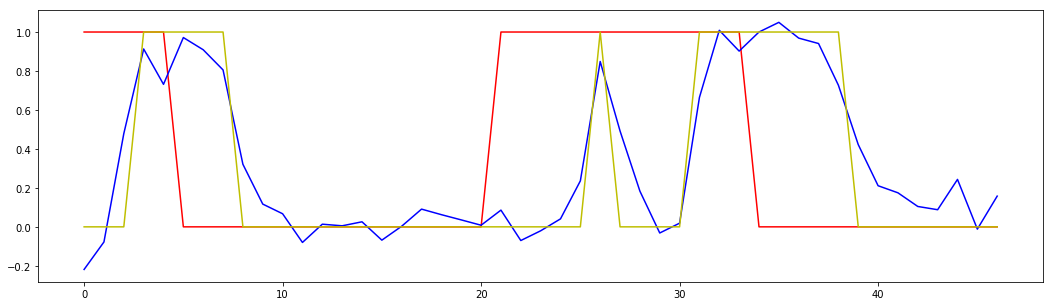

In [557]:
print(len(valid_y))
print(len(valid_logits_list[0]))

index=0

# valid_logits = valid_logits_list[index]
# valid_y = valid_y_list[index]

index1=14

plt.figure(figsize=(18, 5))
start=0
end=1000
plt.plot([i[-1][0] for i in valid_y[index1][start:end]], 'r')
plt.plot([i[-1][0] for i in valid_logits[index1][start:end]], 'b')
plt.plot([round(i[-1][0]) for i in valid_logits[index1][start:end]], 'y')
plt.show()

In [558]:
# print(len(valid_logits), len(valid_logits[0]), len(valid_logits[0][0]))

# print(len(valid_y))
# print(len(valid_y[0]))
# print(len(valid_y[0][0]))  

m1u, m1o, m2u, m2o, m3u, m3o = [], [], [], [], [], []
    
for k in range(len(valid_logits_list)):
    
#     valid_logits = valid_logits_list[k]
#     valid_y = valid_y_list[k]    
    
    valid_y_seq_list, valid_logits_bin_list = [], []

    for t in valid_logits:  
        t_all = [i for i in t[0]]
        t_all.extend([i[-1] for i in t[1:]])
    #     print(len(t_all)-len(t))

        valid_logits_part = [[round(i[0])] for i in t_all]
        for i in range(1, len(valid_logits_part)-1):
            if(valid_logits_part[i-1][0]!=valid_logits_part[i][0] and valid_logits_part[i-1][0]==valid_logits_part[i+1][0]):
                valid_logits_part[i][0]=valid_logits_part[i-1][0]  

        valid_logits_bin_list.append(valid_logits_part)

    for t in valid_y:  
        t_all = [i for i in t[0]]
        t_all.extend([i[-1] for i in t[1:]])
        valid_y_seq_list.append(t_all)

    # print(valid_y_seq_list)

    count = 0
    total = 0
    for i in range(0, len(valid_y_seq_list)):
        total += len(valid_y_seq_list[i])
    #     print(len(valid_y_seq_list[i]), len(valid_logits_bin_list[i]))

        for j in range(0, len(valid_y_seq_list[i])):
            if(valid_y_seq_list[i][j][0] == valid_logits_bin_list[i][j][0]):
                count += 1

    print(count)
    print(total)
    print("valid accuarcy : ", count*1.0/total)
    
    #===========================================
    step_time_actual, step_time_predict= [], []
    step_time_actual_gap = []

    #valid_y_seq_list, valid_logits_bin_list
    for i in range(0, len(valid_y_seq_list)):
        step_time_actual_part, step_time_predict_part= [], []
        for j in range(1, len(valid_y_seq_list[i])):
            if(abs(valid_y_seq_list[i][j][0]-valid_y_seq_list[i][j-1][0])>0.5):
                step_time_actual_part.append(j)
        #     if(abs(valid_logits[i][0]-valid_logits[i-1][0])>0.5):
            if(abs(valid_logits_bin_list[i][j][0]-valid_logits_bin_list[i][j-1][0])>0.5):
                step_time_predict_part.append(j)
        step_time_actual.append(step_time_actual_part)

        #----------------------------
        step_time_predict.append(step_time_predict_part)
        #----------------------------
#         average_time = (step_time_predict_part[-1]-step_time_predict_part[0])/(len(step_time_predict_part)-1)
#         step_time_predict_part_1 = [step_time_predict_part[0]]
#         j = 1
#         while j<len(step_time_predict_part):
#             if(step_time_predict_part[j]-step_time_predict_part_1[-1]>average_time/4):
#                 step_time_predict_part_1.append(step_time_predict_part[j])
#                 j += 1
#             else:
#                 j += 2

#         step_time_predict.append(step_time_predict_part_1)
        #----------------------------------


        step_time_actual_gap_part = []
        step_time_actual_gap_part.append(0)
    #     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
        for i in range(1, len(step_time_actual_part)):
            step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
        step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
        step_time_actual_gap.append(step_time_actual_gap_part)

    print('Step number for each segement')
    print([len(i) for i in step_time_actual])   
    print([len(i) for i in step_time_predict])
    
    #===================================================
    total_step_count = sum([len(i) for i in step_time_actual])
    metric1_undercount = 0
    metric2_undercount = 0
    metric3_undercount = 0
    metric1_overcount = 0
    metric2_overcount = 0
    metric3_overcount = 0
    
    metric1_overcount_list = []
    metric2_overcount_list = []
    metric3_overcount_list = []

    print(len(valid_y))

    for i in range(len(valid_y)):
        step_count = len(step_time_actual[i])
        undercount = 0
        overcount = 0
        
        metric1_overcount += len([t for t in step_time_predict[i] if t<step_time_actual[i][0]])
        for j in range(1, step_count):
            gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
        #     print(gap_count)
            if(len(gap_count)>1):
                overcount += len(gap_count)-1
            if(len(gap_count)<1):
                undercount += 1
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1

        metric1_undercount += undercount
        metric1_overcount += overcount
        metric1_overcount_list.append(overcount)

        undercount = 0
        overcount = 0
        for j in range(1, len(step_time_actual_gap[i])):
            gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
        #     print(gap_count)
            if(len(gap_count)>1):
                overcount += (len(gap_count)-1)
            if(len(gap_count)<1):
                undercount += 1    

        metric2_undercount += undercount
        metric2_overcount += overcount  
        metric2_overcount_list.append(overcount)

        diff = len(step_time_predict[i])-len(step_time_actual[i])
#         print(step_time_actual[i])
#         print(step_time_predict[i])
#         print('------')

        if(diff<0):
    #         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
            metric3_undercount -= diff
            metric3_overcount_list.append(0)
    #     if(diff>=0):
        else:
    #         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
            metric3_overcount += diff
            metric3_overcount_list.append(diff)

    print(len(metric1_overcount_list))
    print(sum(metric1_overcount_list))
    print(metric1_overcount_list)
    print(len(metric3_overcount_list))
    print(sum(metric3_overcount_list))
    print(metric3_overcount_list)

    print('error : ')
    print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
    print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
    print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
    print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
    print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
    print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)
    
    m1u.append(metric1_undercount*1.0/total_step_count)
    m1o.append(metric1_overcount*1.0/total_step_count)
    m2u.append(metric2_undercount*1.0/total_step_count)
    m2o.append(metric2_overcount*1.0/total_step_count)
    m3u.append(metric3_undercount*1.0/total_step_count)
    m3o.append(metric3_overcount*1.0/total_step_count)
    
    
    print("==============================================================")

filename = 'tmp/na_valid_timesteps='+str(timesteps)+'_trainingsteps='+str(training_steps)+'lr='+str(0.1)+'1.csv'
with open(filename,"w") as csvfile: 
    writer = csv.writer(csvfile)

    #先写入columns_name
    writer.writerow(["cv0","cv1","cv2","cv3"])
    #写入多行用writerows
    writer.writerows([m1u, m1o, m2u, m2o, m3u, m3o])
    

13101
22940
valid accuarcy :  0.5710985178727114
Step number for each segement
[6, 9, 49, 6, 6, 9, 49, 6, 7, 69, 8, 6, 7, 69, 8, 6, 73, 19, 73, 19, 18, 72, 9, 70, 9, 52, 9, 18, 72, 9, 70, 9, 52, 9, 48, 23, 39, 18, 24, 19, 73, 23, 39, 18, 24, 19, 73, 34, 67, 34, 67]
[11, 13, 64, 9, 17, 22, 133, 11, 15, 129, 11, 12, 14, 137, 8, 17, 114, 22, 170, 26, 28, 116, 16, 124, 15, 88, 13, 32, 181, 13, 167, 19, 116, 10, 91, 40, 44, 27, 39, 29, 118, 45, 89, 44, 56, 39, 151, 55, 104, 78, 163]
51
51
1559
[4, 4, 22, 2, 10, 12, 84, 5, 6, 62, 2, 4, 6, 69, 0, 8, 52, 6, 97, 9, 9, 50, 7, 60, 3, 37, 4, 14, 109, 8, 97, 11, 67, 3, 43, 19, 11, 12, 17, 11, 50, 21, 51, 29, 34, 21, 84, 25, 46, 45, 97]
51
1481
[5, 4, 15, 3, 11, 13, 84, 5, 8, 60, 3, 6, 7, 68, 0, 11, 41, 3, 97, 7, 10, 44, 7, 54, 6, 36, 4, 14, 109, 4, 97, 10, 64, 1, 43, 17, 5, 9, 15, 10, 45, 22, 50, 26, 32, 20, 78, 21, 37, 44, 96]
error : 
total undercount metric 1:	 0.08374384236453201
total overcount metric 1:	 0.9956896551724138
total undercount me

In [537]:
[2, 2, 27, 2, 0, 1, 11, 5, 2, 31, 0, 0, 0, 48, 6, 10, 55, 8, 19, 21, 8, 50, 1, 51, 4, 22, 4, 15, 2, 26, 3, 16, 4, 13, 8, 21, 4, 13, 18, 7, 19, 6, 42, 0, 10, 34, 10, 5, 6, 31, 0, 12, 2, 30, 0, 0, 10, 0, 27, 3]
60
808
[4, 3, 27, 3, 2, 1, 11, 5, 3, 33, 0, 3, 2, 45, 6, 11, 51, 11, 18, 21, 10, 53, 4, 51, 5, 21, 5, 15, 4, 27, 5, 14, 3, 13, 7, 19, 6, 12, 14, 8, 19, 6, 40, 0, 10, 34, 11, 6, 6, 28, 1, 13, 5, 33, 1, 0, 9, 2, 27, 1]
error : 

SyntaxError: invalid syntax (<ipython-input-537-064cb31106b9>, line 5)